# Initialization

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2  

In [8]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt
    
import numpy as np
import scipy

# Let's import the aln model
from neurolib.models.aln import ALNModel

# Some useful functions are provided here
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [9]:
# Create the model
model = ALNModel()

# Each model comes with a set of default parameters which are a dictionary. 
# Let's change the parameter that controls the duration of a simulation to 10s.
model.params['duration'] = 10.0 * 1000  

# For convenience, we could also use:
model.params.duration = 10.0 * 1000

# In the aln model an Ornstein-Uhlenbeck process is simulated in parallel
# as the source of input noise fluctuations. Here we can set the variance
# of the process. 
# For more info: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process 
# Let's add some noise.
model.params['sigma_ou'] = 0.1

# Finally, we run the model
model.run()

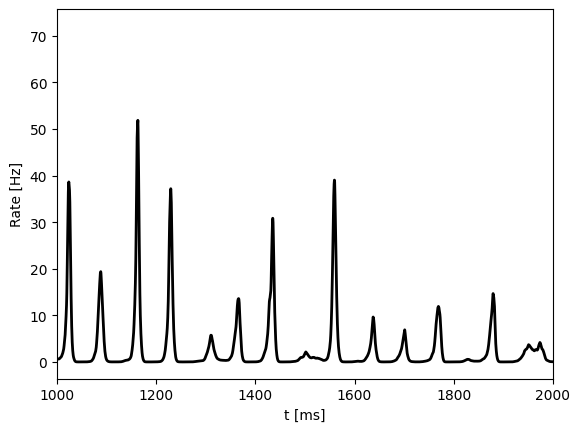

In [4]:
plt.plot(model['t'], model['rates_exc'].T, lw=2, c='k')
plt.xlabel("t [ms]")
plt.ylabel("Rate [Hz]")
plt.xlim(1000, 2000);

# Prepare data

In [10]:
import pandas as pd
import numpy as np

def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])
    
    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation and their labels."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    all_sets = []
    
    for index in fixation_indices:
        # Start from the next row after fixation and take the next 10 timestamps
        period = triggers.iloc[index + 1:index + 11]
        if not period.empty:
            initial_time = period['Time'].iloc[0]
            # Calculate relative times and labels for each event in the period
            relative_times = period['Time'].apply(lambda x: x - initial_time).tolist()
            labels = [1 if typ == 'target' else 0 for typ in period['Type']]
            all_sets.append([np.array(relative_times), np.array(labels)])
    
    return all_sets

trigger_file = '/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt'
triggers = read_triggers(trigger_file)
sets_of_data = extract_fixation_periods(triggers)

# Example: print each set of relative times and corresponding labels
for i, data_set in enumerate(sets_of_data):
    print(f"Set {i + 1}: Times - {data_set[0]}, Labels - {data_set[1]}")

Set 1: Times - [0.        0.3029036 0.6023459 0.9037853 1.2040812 1.503317  1.8020343
 2.1018928 2.4021984 2.7019903], Labels - [0 0 0 0 0 1 0 0 0 0]
Set 2: Times - [0.        0.3014903 0.6025641 0.9044065 1.204575  1.5057789 1.8059298
 2.1059192 2.4052828 2.7069683], Labels - [0 0 0 0 0 1 0 0 0 0]
Set 3: Times - [0.        0.300937  0.5999928 0.8998687 1.1997361 1.4991347 1.7995076
 2.0995057 2.3979604 2.6993967], Labels - [0 0 1 0 0 0 0 0 0 0]
Set 4: Times - [0.        0.3002152 0.6008505 0.9006335 1.2015983 1.5016736 1.8006985
 2.1019378 2.4039317 2.7032683], Labels - [0 0 0 0 0 0 0 0 0 1]
Set 5: Times - [0.        0.3014637 0.6035617 0.9036849 1.2038939 1.5031788 1.8053971
 2.1043517 2.4057954 2.7044866], Labels - [0 0 0 1 0 0 0 0 0 0]
Set 6: Times - [0.        0.300075  0.6026192 0.9034947 1.204099  1.5035831 1.8036683
 2.1037185 2.4040527 2.7035041], Labels - [0 0 0 0 0 1 0 0 0 0]
Set 7: Times - [0.        0.3003657 0.6010963 0.9005977 1.1999094 1.4982391 1.7987962
 2.0979808 2.3

In [15]:
print(sets_of_data[0])

[array([0.       , 0.3029036, 0.6023459, 0.9037853, 1.2040812, 1.503317 ,
       1.8020343, 2.1018928, 2.4021984, 2.7019903]), array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])]


In [11]:
import pandas as pd

def read_triggers(trigger_file):
    """Reads triggers from a file and returns a DataFrame."""
    with open(trigger_file, 'r') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 3:
            label, type_, time = parts
            data.append([label, type_, float(time)])
    
    return pd.DataFrame(data, columns=['Label', 'Type', 'Time'])

def extract_fixation_periods(triggers):
    """Extracts periods of the next 10 timestamps after each fixation."""
    fixation_indices = triggers[triggers['Label'] == '+'].index
    periods = []
    
    for index in fixation_indices:
        # Check if there are at least 10 entries after the fixation index
        end_index = index + 11
        if end_index > len(triggers):
            end_index = len(triggers)
        period = triggers.iloc[index + 1:end_index]
        if not period.empty:
            periods.append(period['Time'].tolist())
    
    return periods

def extract_data_from_intervals(raw_data_file, periods):
    """Extracts data rows corresponding to each period of timestamps and adds a column for the average of selected columns."""
    raw_data = pd.read_csv(raw_data_file, skiprows=2)
    results = []
    
    for period in periods:
        if period:
            # Get the start and end timestamps of the period
            start_time = period[0]
            end_time = period[-1]
            
            # Filter the data
            filtered_data = raw_data[(raw_data['lsl_timestamp'] >= start_time) & (raw_data['lsl_timestamp'] <= end_time)]
            filtered_data['relative_time'] = filtered_data['lsl_timestamp'] - start_time
            # Calculate the average of certain columns, excluding some
            cols_to_avg = filtered_data.columns.difference(['lsl_timestamp', 'timestamp', 'relative_time', 'TRG'])
            filtered_data['average'] = filtered_data[cols_to_avg].mean(axis=1)
            results.append(filtered_data)
    
    return results


trigger_file = '/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/triggers.txt'
raw_data_file = '/Users/aliag/Desktop/Data/S001/S001_Matrix_Calibration_Mon_15_May_2023_10hr39min42sec_-0400/raw_data.csv'

triggers = read_triggers(trigger_file)
fixation_periods = extract_fixation_periods(triggers)
filtered_data_sets = extract_data_from_intervals(raw_data_file, fixation_periods)

# Example: print the number of rows in each filtered data set
for i, data in enumerate(filtered_data_sets):
    print(f"Data Set {i + 1} contains {len(data)} rows.")


Data Set 1 contains 810 rows.
Data Set 2 contains 810 rows.
Data Set 3 contains 810 rows.
Data Set 4 contains 810 rows.
Data Set 5 contains 810 rows.
Data Set 6 contains 810 rows.
Data Set 7 contains 810 rows.
Data Set 8 contains 837 rows.
Data Set 9 contains 810 rows.
Data Set 10 contains 810 rows.
Data Set 11 contains 810 rows.
Data Set 12 contains 810 rows.
Data Set 13 contains 810 rows.
Data Set 14 contains 810 rows.
Data Set 15 contains 819 rows.
Data Set 16 contains 810 rows.
Data Set 17 contains 819 rows.
Data Set 18 contains 810 rows.
Data Set 19 contains 810 rows.
Data Set 20 contains 810 rows.
Data Set 21 contains 810 rows.
Data Set 22 contains 810 rows.
Data Set 23 contains 819 rows.
Data Set 24 contains 810 rows.
Data Set 25 contains 819 rows.
Data Set 26 contains 810 rows.
Data Set 27 contains 819 rows.
Data Set 28 contains 810 rows.
Data Set 29 contains 810 rows.
Data Set 30 contains 837 rows.
Data Set 31 contains 810 rows.
Data Set 32 contains 810 rows.
Data Set 33 conta

/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_57852/2676490405.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['relative_time'] = filtered_data['lsl_timestamp'] - start_time
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_57852/2676490405.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['average'] = filtered_data[cols_to_avg].mean(axis=1)
/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_57852/2676490405.py:46: SettingWithCopyWarning: 
A 

# Plot signals

In [36]:
import numpy as np

# Example time and value arrays
time_array = data_set[0]
value_array = data_set[1]

# Calculate new_size as an integer multiple of the original time duration
new_size = int(time_array[-1] * 1000)  # Convert to integer

# Generate new time array with interpolated values
new_time_array_3 = np.linspace(time_array[0], time_array[-1], new_size)

# Expand the value array to match the new time array, propagating labels
new_value_array_3 = np.zeros_like(new_time_array_3)

# Propagate values by setting the range of 1's between known points
for i, value in enumerate(value_array):
    if value == 1:
        if i < len(value_array) - 1:
            next_change_index = np.where(value_array[i+1:] != value)[0]
            if len(next_change_index) > 0:
                end_time = time_array[i + 1 + next_change_index[0]]
            else:
                end_time = new_time_array_3[-1]
        else:
            end_time = new_time_array_3[-1]
        start_index = np.searchsorted(new_time_array_3, time_array[i])
        end_index = np.searchsorted(new_time_array_3, end_time)
        new_value_array_3[start_index:end_index] = 1

# Output the new time array and the updated value array for verification
new_time_array_3, new_value_array_3


(array([0.00000000e+00, 1.00072918e-03, 2.00145837e-03, ...,
        2.70697244e+00, 2.70797317e+00, 2.70897390e+00]),
 array([0., 0., 0., ..., 0., 0., 0.]))

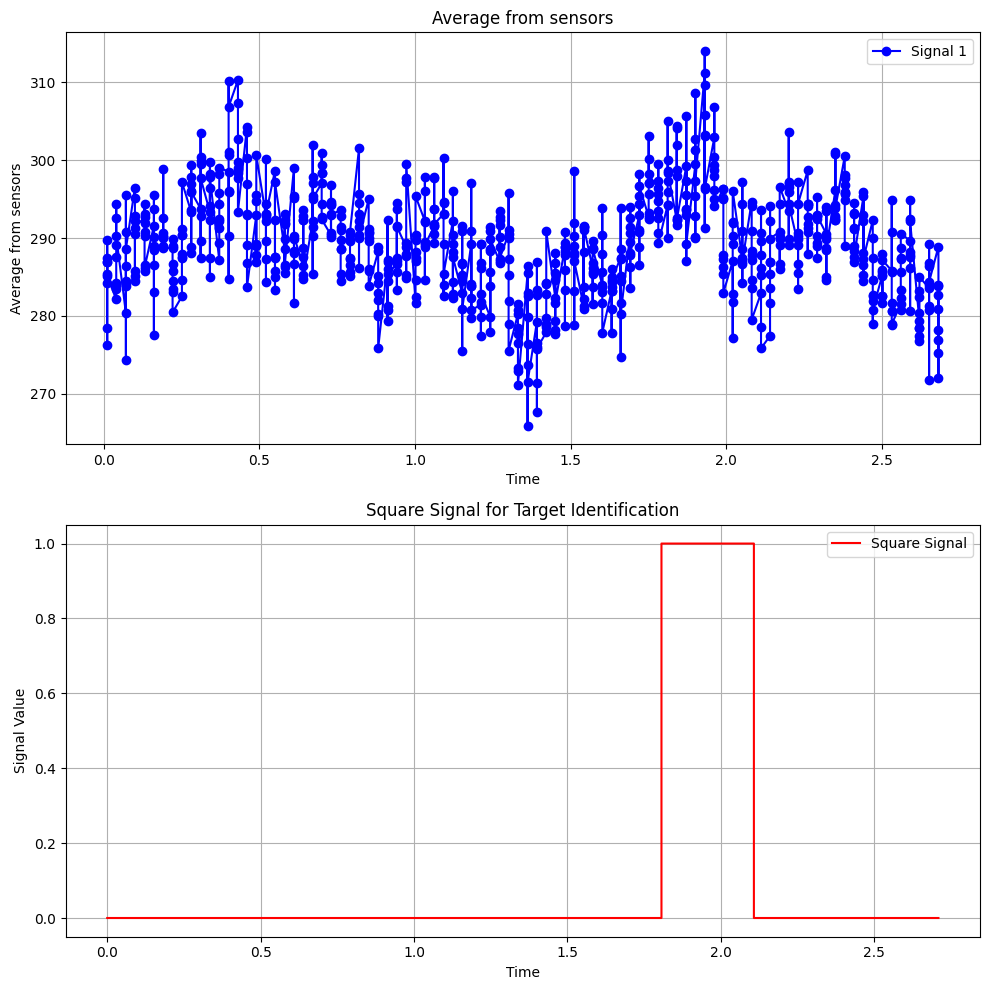

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example arrays
time_array_1 = filtered_data_sets[0]['relative_time']  # Time data for the first signal
value_array_1 = filtered_data_sets[0]['average']  # Corresponding values for the first signal
# Given time and value arrays
time_array_2 = data_set[0]
value_array_2 = data_set[1]

# Calculate new_size as an integer multiple of the original time duration
new_size = int(time_array[-1] * 1000)  # Convert to integer

# Generate new time array with interpolated values
new_time_array_2 = np.linspace(time_array[0], time_array[-1], new_size)

# Expand the value array to match the new time array, propagating labels
new_value_array_2 = np.zeros_like(new_time_array_3)

# Propagate values by setting the range of 1's between known points
for i, value in enumerate(value_array):
    if value == 1:
        if i < len(value_array) - 1:
            next_change_index = np.where(value_array[i+1:] != value)[0]
            if len(next_change_index) > 0:
                end_time = time_array[i + 1 + next_change_index[0]]
            else:
                end_time = new_time_array_2[-1]
        else:
            end_time = new_time_array_2[-1]
        start_index = np.searchsorted(new_time_array_2, time_array[i])
        end_index = np.searchsorted(new_time_array_2, end_time)
        new_value_array_2[start_index:end_index] = 1

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 plots, vertically stacked

# Plot the first data set
axs[0].plot(time_array_1, value_array_1, marker='o', linestyle='-', color='b', label='Signal 1')
axs[0].set_title('Average from sensors')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average from sensors')
axs[0].grid(True)
axs[0].legend()

# Plot the second data set (modified for square signal)
axs[1].step(new_time_array_2, new_value_array_2, where='post', linestyle='-', color='r', label='Square Signal')
axs[1].set_title('Square Signal for Target Identification')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Signal Value')
axs[1].grid(True)
axs[1].legend()

# Automatically adjust subplot params so that the subplot(s) fits in to the figure area.
plt.tight_layout()

# Display the plot
plt.show()

In [49]:
len(new_value_array_2)

2708

# Generate firing rates with stimulus

In [ ]:
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim

In [71]:
model.params['duration']=270.8
square_signal=np.array([new_value_array_2,new_time_array_2])
model.params["ext_exc_current"] = square_signal
model.run()

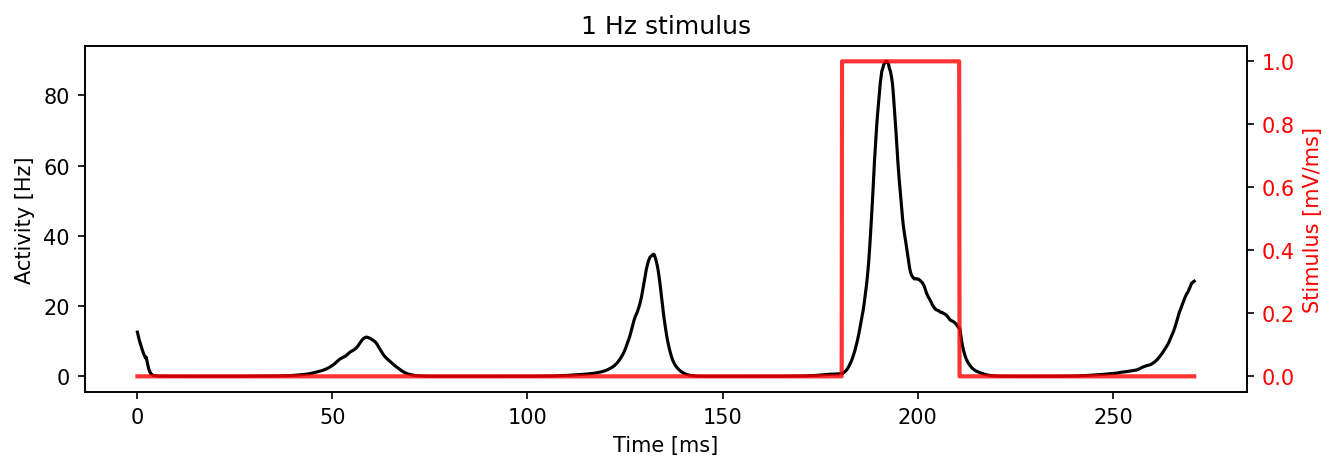

In [78]:
plt.figure(figsize=(10, 3), dpi=150)
plt.title("1 Hz stimulus")
ax1 = plt.gca()
ax1.plot(model.t, model.output.T, c="k")
ax2 = plt.gca().twinx()
ax2.plot(model.t, square_signal[0].squeeze(), lw=2, c="r", alpha=0.8)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Activity [Hz]")
ax2.set_ylabel("Stimulus [mV/ms]", color="r")
ax2.set_ylabel("Stimulus [mV/ms]", color="r")
ax2.tick_params(axis="y", labelcolor="r")